# Auto-cross-correlogram

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
#from fitting_functions import cross_validate_model
#from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmp2cwr8wlw/cache.zip Bytes: 113759462


100%|██████████| 108.48947715759277/108.48947715759277 [00:14<00:00,  7.32it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [3]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

## PCA on data samples

In [4]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = matrix_all[mat][0] # (n_samples, n_features)
#X = np.array(design_matrix)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))


Text(0, 0.5, '% Variance explained')

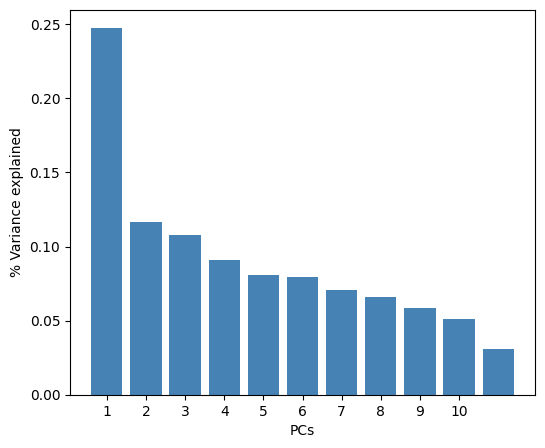

In [5]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

In [6]:
# Normalize PC projections
scaler = StandardScaler()

# Fit and transform the data
normalized_projections = scaler.fit_transform(X_reduced)  # TODO: is projections the accurate term here?
#normalized_projections = scaler.fit_transform(X)


### Get bin information

In [7]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['Bin'], index=range(len(normalized_projections)))
augmented_data['Bin'] = design_matrix['Bin']
augmented_data['pc1'] = normalized_projections[:, 0].transpose()
augmented_data['pc2'] = normalized_projections[:, 1].transpose()
augmented_data['pc3'] = normalized_projections[:, 2].transpose()
augmented_data['pc4'] = normalized_projections[:, 3].transpose()
augmented_data['pc5'] = normalized_projections[:, 4].transpose()
augmented_data['pc6'] = normalized_projections[:, 5].transpose()
augmented_data['pc7'] = normalized_projections[:, 6].transpose()
augmented_data['pc8'] = normalized_projections[:, 7].transpose()
augmented_data['pc9'] = normalized_projections[:, 8].transpose()
augmented_data['pc10'] = normalized_projections[:, 9].transpose()

In [8]:
shuffled_data = augmented_data.copy()[np.array(pcs)]
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)

NameError: name 'pcs' is not defined

Text(0.5, 0, 'Time lag (ms)')

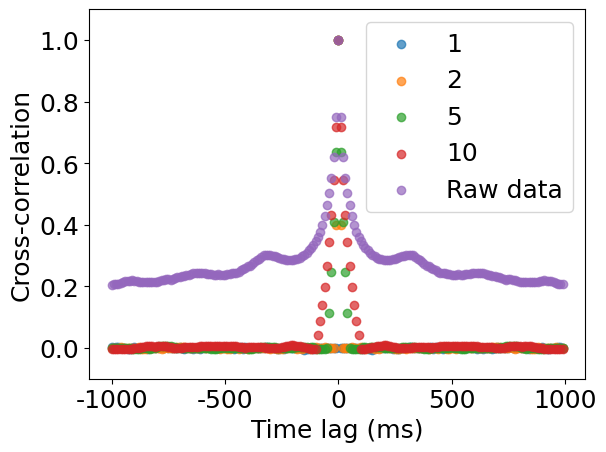

In [98]:
pcs = augmented_data.keys()[1:]
lags_to_plot = 100

chunk_sizes = [1, 2, 5, 10]

for c, chunk_size in enumerate(chunk_sizes):

    # Split the DataFrame into chunks
    chunks = [augmented_data.iloc[i:i + chunk_size] for i in range(0, len(augmented_data), chunk_size)]
    # # Shuffle each chunk independently
    # shuffled_chunks = [chunk.sample(frac=1) for chunk in chunks]
    # # Concatenate the shuffled chunks back together
    # shuffled_data = pd.concat(shuffled_chunks, ignore_index=True)

    shuffle_idx = np.random.permutation(np.array(chunks).shape[0])
    a = np.array(chunks)[shuffle_idx]
    b = a.reshape((np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2]))
    shuffled_data = pd.DataFrame(b)


    #fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])

    corrs = []
    corrs_shuf = []

    for i, pc in enumerate(pcs):
        
        x = augmented_data[pc]
        x_shuf = shuffled_data[i]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        cross_correlation_shuf = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])
                
                x_chunk_shuf = np.array(x_shuf[-lag:])
                y_chunk_shuf = np.array(x_shuf[:lag])            
                
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

                x_chunk_shuf = np.array(x_shuf)
                y_chunk_shuf = np.array(x_shuf)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
                x_chunk_shuf = np.array(x_shuf[0:-lag])
                y_chunk_shuf = np.array(x_shuf[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            cross_correlation_shuf[l] = stats.pearsonr(x_chunk_shuf, y_chunk_shuf).statistic

        # Save data
        if i == 0:
            corrs = [cross_correlation]
            corrs_shuf = [cross_correlation_shuf]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            corrs_shuf = np.vstack((corrs_shuf, cross_correlation_shuf))

    #     # Plot the cross-correlation
    #     ax[i].scatter(lags, cross_correlation, label='Raw data')
    #     ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data')    
    #     ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    #     ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
    #     ax[i].set_xlabel('Lag')
    #     ax[i].set_ylabel('Cross-Correlation')
    #     ax[i].set_title(pc)
    #     ax[i].set_ylim([0, 1])
                
    #     plt.tight_layout()
    # plt.show()

    
    plt.scatter(lags, np.mean(corrs_shuf, axis=0), alpha=0.7, label=str(chunk_size))
    
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-.1, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-1000, -500, 0, 500, 1000])
# Add labels and legend
plt.xlabel('Time lag (ms)')
#plt.xlim([0, 35])


The rate at which this autocorrelogram declines in a behaving mouse may be characterized as a time-constant, tau, of an exponentially decaying curve. Tau was fit using the Levenberg-Marquardt algorithm (non-linear least squares) using the SciPy optimization package.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


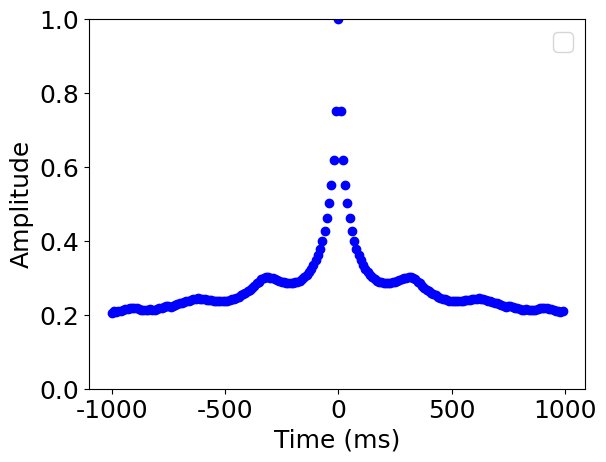

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Define the exponentially decaying function
def exponential_decay(x, tau):
    return np.exp(-x / tau)

# Define the residual function
def residual(tau, x, y):
    return exponential_decay(x, tau) - y


x_data = lags
y_data = np.mean(corrs, axis=0)

# # Generate synthetic data with some noise
# np.random.seed(42)
# x_data = np.linspace(0, 5, 100)
# true_tau = 1.5
# y_data = exponential_decay(x_data, tau=true_tau) + 0.1 * np.random.normal(size=len(x_data))

# # Plot the synthetic data
# plt.scatter(x_data, y_data, label='Synthetic Data')

# Provide an initial guess for tau
initial_guess_tau = 1

# Use least_squares to fit the decay constant (tau)
result = least_squares(residual, initial_guess_tau, args=(x_data, y_data))

# Extract the fitted tau from the result
fitted_tau = result.x[0]

# Generate the fitted curve using the fitted tau
y_fit = exponential_decay(x_data, fitted_tau)

# Plot the fitted curve
#plt.plot(x_data, y_fit, label=f'Fitted Curve (tau={fitted_tau:.2f})', color='red')
plt.scatter(x_data, y_data,  color='blue') # label='Raw data',
plt.ylim([0,1])
plt.xticks([-100, -50, 0, 50, 100], [-1000, -500, 0, 500, 1000])
# Add labels and legend
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


([<matplotlib.axis.XTick at 0x7fba0409c4c0>,
 [Text(20, 0, '200'),
  Text(40, 0, '400'),
  Text(60, 0, '600'),
  Text(80, 0, '800')])

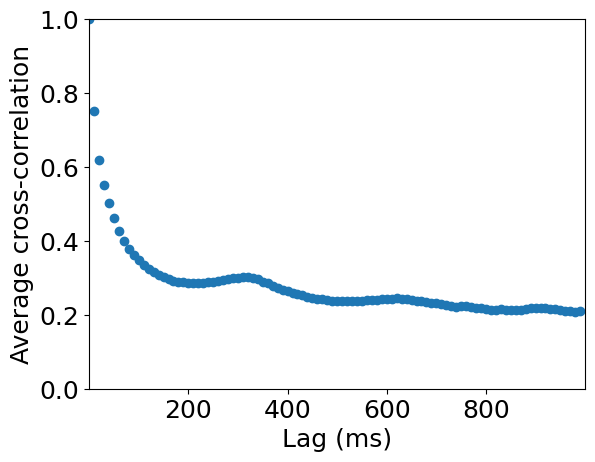

In [11]:
plt.scatter(lags, np.mean(corrs, axis=0))
plt.ylim([0, 1])
plt.xlabel('Lag (ms)')
plt.ylabel('Average cross-correlation')
plt.xlim([0, 100])
plt.xticks([20, 40, 60, 80], [200, 400, 600, 800])